In [36]:
#imports
import math, subprocess
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
import os
from os import listdir, path
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
paths = [
    "Resultados",
    "Data"
]
def crearPaths(paths=paths):
    for p in paths:    
        if not path.exists(f"{os.getcwd()}/{p}"):
            os.mkdir(f"{os.getcwd()}/{p}")
crearPaths()

In [38]:
#correr experimentos (ver como hay que modificar con lo de usar python y c++ juntos)
def correr_experimento(archivo_training, archivo_testing, archivo_salida, k, metodo, nitter, epsilon, alfa):
        
    # Crear proceso para ejecutar el codigo.
    if metodo == '0':
        process = subprocess.Popen(["./build/tp2", archivo_training, archivo_testing, archivo_salida, k, metodo], stderr=subprocess.PIPE, stdout=subprocess.PIPE, stdin=subprocess.PIPE, universal_newlines = True)
    else:
        process = subprocess.Popen(["./build/tp2", archivo_training, archivo_testing, archivo_salida, k, metodo, nitter, epsilon, alfa], stderr=subprocess.PIPE, stdout=subprocess.PIPE, stdin=subprocess.PIPE, universal_newlines = True)

    # Poner la instancia en la entrada estandar y leer salida de STDERR con el tiempo de ejecución.
    stdout, stderr = process.communicate() # communicate() devuelve una tupla (stdout, stderr)

    tiempo_de_ejecucion = str.splitlines(stderr)[0]
    #print(clog)

    # Correr experimento.
    exit_code = process.wait()

    # Verificar que el proceso no fallo.
    if exit_code != 0: raise(F"Hubo un error en la experimentacion con el metodo {'kNN' if metodo == 0 else 'PCA'} con los parámetros {archivo_training}, {archivo_testing}, k:{k} {', nitter:'+nitter if metodo == 1 else ''} {', epsilon:'+epsilon if metodo == 1 else ''} {', alfa:'+alfa if metodo == 1 else ''}.")
    return float(tiempo_de_ejecucion)


In [39]:
class Experimento:
    def __init__(self, trainingDataset, testingDataset, outputFile, metodo, vecinos, num_iter, alfa, epsilon):
        self.trainingDataset = trainingDataset
        self.testingDataset = testingDataset
        self.outputFile = outputFile
        self.metodo = metodo
        self.vecinos = vecinos
        self.num_iter = num_iter
        self.alfa = alfa
        self.epsilon = epsilon

    def display(self):
        display(f"Archivo De Entrenamiento: {self.trainingDataset}")
        display(f"Archivo De Prueba: {self.testingDataset}")
        display(f"Archivo De Salida: {self.outputFile}")
        display(f"Metodo: {self.metodo}")
        display(f"Vecinos: {self.vecinos}")
        display(f"Numero De Iteraciones: {self.num_iter}")
        display(f"Alfa: {self.alfa}")
        display(f"Epsilon: {self.epsilon}")

In [40]:
def reduceDataset(n):
    dataset = pd.read_csv("train.csv")
    reducedDataset = resample(dataset, replace = False, n_samples = n)
    return reducedDataset


def splitDataset(dataset, testSize=0.3): #default 70-30 como el fernet
    train, test = train_test_split(dataset, test_size=testSize);
    train.to_csv(path_or_buf="Data/random_train.csv", index=False)
    test.to_csv(path_or_buf="Data/random_validate.csv", index=False)
    return[train, test]


#obsoleta
def k_foldDataset(dataset, k):
    kf = KFold(n_splits=k, shuffle=True)
    fold_indices = kf.split(X=dataset)
    for key, indices in enumerate(fold_indices, 1):
        train_indices = indices[0]
        #test_indices = indices[1]
        fold_train_dataset = dataset.filter(items=train_indices, axis=0) 
        #fold_test_dataset = dataset.filter(items=test_indices, axis=0) 
        fold_train_dataset.to_csv(path_or_buf=f"Data/{k}_fold-{key}.csv", index=False)
        #fold_test_dataset.to_csv(path_or_buf=f"Data/{k}_fold-{key}-test.csv", index=False)
    

In [41]:
#si se corre dos veces sobre la misma cantidad de folds pisa los archivos
def prepareDataSet(size, folds):
    reducedDataset = reduceDataset(size);
    kf = KFold(n_splits=folds, shuffle=True)
    fold_splits = kf.split(X=reducedDataset)

    for key, split in enumerate(fold_splits, 1):
        training_indices = split[0]
        validate_indices = split[1]

        trainDataset = reducedDataset.iloc[training_indices]
        validateDataset = reducedDataset.iloc[validate_indices]
        
        trainDataset.to_csv(path_or_buf=f"Data/{folds}_fold-SET-{key}-train.csv", index=False)
        validateDataset.to_csv(path_or_buf=f"Data/{folds}_fold-SET-{key}-validate.csv", index=False)
                

In [42]:
#Generar experimentos para busqueda de mejor k de knn sin pca en un 5-fold del dataset reducido
def generarExperimentosKnnVariandoK(folds, minK, maxK, step):
    Exp = []
    for key in range(1,folds+1):
        Exp += [ Experimento(
            f"./Data/{folds}_fold-SET-{key}-train.csv",
            f"./Data/{folds}_fold-SET-{key}-validate.csv",
            f"./resultados/{folds}_fold-SET-{key}-{k}-vecinos-resultados.csv",
            "0",
            f"{k}",
            None,
            None,
            None
        ) for k in range(minK, maxK+1, step)]
    return Exp
    
def generarExperimentosPCAVariandoK(folds, minK, maxK, step, num_iter, alfa, epsilon):
    Exp = []
    for key in range(1,folds+1):
        Exp += [ Experimento(
            f"./Data/{folds}_fold-SET-{key}-train.csv",
            f"./Data/{folds}_fold-SET-{key}-validate.csv",
            f"./resultados/{folds}_fold-SET-{key}-{k}-vecinos-resultados.csv",
            "1",
            f"{k}",
            f"{num_iter}",
            f"{alfa}",
            f"{epsilon}"
        ) for k in range(minK, maxK+1, step)]
    return Exp

def generarExperimentosPCAVariandoNumIter(folds, k, minNum_iter, maxNum_iter, step, alfa, epsilon):
    Exp = []
    for key in range(1,folds+1):
        Exp += [ Experimento(
            f"./Data/{folds}_fold-SET-{key}-train.csv",
            f"./Data/{folds}_fold-SET-{key}-validate.csv",
            f"./resultados/{folds}_fold-SET-{key}-{k}-vecinos-resultados.csv",
            "1",
            f"{k}",
            f"{num_iter}",
            f"{alfa}",
            f"{epsilon}"
        ) for num_iter in range(minNum_iter, maxNum_iter+1, step)]
    return Exp

def generarExperimentosPCAVariandoAlfa(folds, k, num_iter, minAlfa, maxAlfa, step, epsilon):
    Exp = []
    for key in range(1,folds+1):
        Exp += [ Experimento(
            f"./Data/{folds}_fold-SET-{key}-train.csv",
            f"./Data/{folds}_fold-SET-{key}-validate.csv",
            f"./resultados/{folds}_fold-SET-{key}-{k}-vecinos-resultados.csv",
            "1",
            f"{k}",
            f"{num_iter}",
            f"{alfa}",
            f"{epsilon}"
        ) for alfa in range(minAlfa, maxAlfa+1, step)]
    return Exp

def generarExperimentosPCAVariandoEpsilon(folds, k, num_iter, alfa, minEpsilon, maxEpsilon, step=1):
    Exp = []
    for key in range(1,folds+1):
        Exp += [ Experimento(
            f"./Data/{folds}_fold-SET-{key}-train.csv",
            f"./Data/{folds}_fold-SET-{key}-validate.csv",
            f"./resultados/{folds}_fold-SET-{key}-{k}-vecinos-resultados.csv",
            "1",
            f"{k}",
            f"{num_iter}",
            f"{alfa}",
            f"{epsilon}"
        ) for epsilon in range(minEpsilon, maxEpsilon+1, step)]
    return Exp

In [43]:
def extractLabelsFrom(archivo):
    dataset = pd.read_csv(archivo);
    labels = dataset[dataset.columns[0]]
    return labels


def calculateAccuracy(sourceFile, resultsFile):
    expectedLabels = extractLabelsFrom(sourceFile)
    resultLabels = extractLabelsFrom(resultsFile)
    
    hits = 0
    for index, result in enumerate(resultLabels):
        if result == expectedLabels[index]:
            hits += 1
    accuracy = hits/len(expectedLabels)
    return accuracy

def kConMejorAccuracy(metodo, folds, n_from, n_to, step=1):
    df_resultado = pd.read_csv("./resultados/resultado.csv")

    maxAccuracy = 0
    maxAccuracyK = 1
    for i in range(n_from, n_to+1, step):
        df = df_resultado[(df_resultado["Método"] == metodo) & (df_resultado["Vecinos"] == i) & (str(df_resultado["SetEntrenamiento"]).find(str(folds), 0, 3))]
        
        accuracy = np.median(df["Accuracy"])
        print(f"{i}: " + str(accuracy))

        if accuracy > maxAccuracy:
            maxAccuracy = accuracy
            maxAccuracyK = i

    print("Mejor k: " + str(maxAccuracyK) + "\ncon un valor de: " + str(maxAccuracy))
    return maxAccuracyK

def numIterYAlfaConMejorAccuracy(folds, alfa_from, alfa_to, alfa_step, numIter_from, numIter_to, numIter_step):
    df_resultado = pd.read_csv("./resultados/resultado.csv")

    maxAccuracy = 0
    maxAccuracyAlfa = 1
    maxAccuracyNumIter = 1
    for num_iter in range(numIter_from, numIter_to+1, numIter_step):
        for alfa in range(alfa_from, alfa_to+1, alfa_step):
            df = df_resultado[(df_resultado["Método"] == 1) & (df_resultado["Numero de iteraciones"] == num_iter) & (df_resultado["Alfa"] == alfa) & (str(df_resultado["SetEntrenamiento"]).find(str(folds), 0, 3))]
            
            accuracy = np.median(df["Accuracy"])
            print(f"Alfa: {alfa} y NumIter: {num_iter} :" + str(accuracy))

            if accuracy > maxAccuracy:
                maxAccuracy = accuracy
                maxAccuracyAlfa = alfa
                maxAccuracyNumIter = num_iter

    print("Mejor alfa: " + str(maxAccuracyAlfa) + "\nMejor cantidad de iteraciones: " + str(maxAccuracyNumIter) + "\ncon un valor de: " + str(maxAccuracy))
    return [maxAccuracyNumIter, maxAccuracyAlfa]

def precisionAndRecallMulticase(sourceFile, resultsFile):
    expectedLabels = extractLabelsFrom(sourceFile)
    resultLabels = extractLabelsFrom(resultsFile)

    truePositives = np.array([0,0,0,0,0,0,0,0,0,0])
    falsePositives = np.array([0,0,0,0,0,0,0,0,0,0])
    falseNegatives = np.array([0,0,0,0,0,0,0,0,0,0])
    for index, result in enumerate(resultLabels):
        if result == expectedLabels[index]:
            truePositives[int(result)] += 1
        elif result != expectedLabels[index]:
            falsePositives[int(result)] += 1
            falseNegatives[int(expectedLabels[index])] += 1

    precisions = np.around(np.divide(truePositives, (truePositives + falsePositives)), 4)
    recalls = np.around(np.divide(truePositives, (truePositives + falseNegatives)), 4)

    return [precisions, recalls]




In [44]:
def correr_experimentos(experimentos):
    if not path.exists("./resultados/resultado.csv"):
        columnas=["SetEntrenamiento", "SetTesting", "Resultados", "Método", "Vecinos", "Numero de iteraciones", "Alfa", "Epsilon", "Tiempo", "Accuracy", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "p7","p8", "p9", "r0", "r1", "r2", "r3", "r4", "r5", "r6", "r7","r8", "r9"]
        df_resultado = pd.DataFrame([], columns=columnas);
    else:
        df_resultado = pd.read_csv("./resultados/resultado.csv")

    iteraciones = 5 #PONER EN 5 PARA LA CORRIDA OFICIAL
    for index, experimento in enumerate(experimentos):
        clear_output(wait=True)
        display(f"Experimento: {index+1} de {len(experimentos)} info:")
        experimento.display()
        
        tiempos = []
        for i in range(0, iteraciones):
            tiempo = correr_experimento(
                experimento.trainingDataset, 
                experimento.testingDataset, 
                experimento.outputFile, 
                experimento.vecinos, 
                experimento.metodo, 
                experimento.num_iter, 
                experimento.epsilon, 
                experimento.alfa
            )
            tiempos.append(tiempo)
                
        tiempo_promedio = np.median(tiempos)

        accuracy = calculateAccuracy(experimento.testingDataset, experimento.outputFile)
        [precisions, recalls] = precisionAndRecallMulticase(experimento.testingDataset, experimento.outputFile)
        os.remove(experimento.outputFile) #Una vez calculadas las métricas no nos sirven creo, y asi ahorramos espacio

        if experimento.metodo == "0":
            idList = df_resultado.index[(df_resultado["SetEntrenamiento"] == experimento.trainingDataset)
                                        & (df_resultado["SetTesting"] == experimento.testingDataset) 
                                        & (df_resultado["Resultados"] == experimento.outputFile)
                                        & (df_resultado["Método"] == int(experimento.metodo))
                                        & (df_resultado["Vecinos"] == int(experimento.vecinos))
                                        ].tolist()
        else:
            idList = df_resultado.index[(df_resultado["SetEntrenamiento"] == experimento.trainingDataset)
                                        & (df_resultado["SetTesting"] == experimento.testingDataset) 
                                        & (df_resultado["Resultados"] == experimento.outputFile)
                                        & (df_resultado["Método"] == int(experimento.metodo))
                                        & (df_resultado["Vecinos"] == int(experimento.vecinos))
                                        & (df_resultado["Alfa"] == int(experimento.alfa))
                                        & (df_resultado["Numero de iteraciones"] == int(experimento.num_iter))
                                        & (df_resultado["Epsilon"] == float(experimento.epsilon))
                                        ].tolist()
        if len(idList) > 1:
            print("ERROR: Falta filtrar mejor la fila o hay experimentos repetidos")
            df_resultado.to_csv("./resultados/resultado.csv", index=False, header=True);
            break
        elif len(idList) == 0:
            df_resultado = pd.concat([df_resultado, pd.DataFrame([[experimento.trainingDataset, experimento.testingDataset, experimento.outputFile, experimento.metodo, experimento.vecinos, experimento.num_iter, experimento.alfa, experimento.epsilon] + [None for j in range(22)]], columns=df_resultado.columns)], ignore_index=True)
            if experimento.metodo == "0":
                idList = df_resultado.index[(df_resultado["SetEntrenamiento"] == experimento.trainingDataset)
                                            & (df_resultado["SetTesting"] == experimento.testingDataset) 
                                            & (df_resultado["Resultados"] == experimento.outputFile)
                                            & (df_resultado["Método"] == experimento.metodo)
                                            & (df_resultado["Vecinos"] == experimento.vecinos)
                                            ].to_list()
            else:
                idList = df_resultado.index[(df_resultado["SetEntrenamiento"] == experimento.trainingDataset)
                                            & (df_resultado["SetTesting"] == experimento.testingDataset) 
                                            & (df_resultado["Resultados"] == experimento.outputFile)
                                            & (df_resultado["Método"] == experimento.metodo)
                                            & (df_resultado["Vecinos"] == experimento.vecinos)
                                            & (df_resultado["Numero de iteraciones"] == experimento.num_iter)
                                            & (df_resultado["Alfa"] == experimento.alfa)
                                            & (df_resultado["Epsilon"] == experimento.epsilon)
                                            ].tolist()  
            
        
        id = idList[0]
      
        df_resultado.loc[id, 'Tiempo'] = tiempo_promedio
        df_resultado.loc[id, 'Accuracy'] = accuracy
        for j in range(10):
            df_resultado.loc[id, f'p{j}'] = precisions[j]
            df_resultado.loc[id, f'r{j}'] = recalls[j]

        df_resultado.to_csv("./resultados/resultado.csv", index=False, header=True);



In [45]:
folds = 5
experimentos = []

# prepareDataSet(10000, folds)
# experimentos = generarExperimentosKnnVariandoK(folds, 1, 1001, 50)
# correr_experimentos(experimentos)

# kConMejorAccuracy(0, 5, 1, 1001, 50)

# prepareDataSet(42000, folds)
# experimentos = generarExperimentosKnnVariandoK(folds, 1, 51, 10)
# correr_experimentos(experimentos)

# kConMejorAccuracy(0, 5, 1, 51, 10)

# experimentos = generarExperimentosKnnVariandoK(folds, 1, 10, 1)
# correr_experimentos(experimentos)

# kConMejorAccuracy(0, 5, 1, 10)

# experimentos = generarExperimentosPCAVariandoK(folds, 1, 51, 10, 1000, 20, 0.000001)
# correr_experimentos(experimentos)

#kConMejorAccuracy(1, 5, 1, 51, 10)

# experimentos = generarExperimentosPCAVariandoK(folds, 21, 41, 5, 1000, 20, 0.000001)
# correr_experimentos(experimentos)

# kConMejorAccuracy(1, 5, 21, 41, 5)

# experimentos = generarExperimentosPCAVariandoK(folds, 21, 31, 1, 1000, 20, 0.000001)
# correr_experimentos(experimentos)

#kConMejorAccuracy(1, 5, 21, 31, 1)

mejorK = 27

# for num_iter in range(1, 1002, 100):
#     experimentos += generarExperimentosPCAVariandoAlfa(folds, mejorK, num_iter, 1, 28, 3, 0.000001)

# correr_experimentos(experimentos)

#numIterYAlfaConMejorAccuracy(folds, 1, 28, 3, 1, 1001, 100)

numIterElegido = 200
experimentos = generarExperimentosPCAVariandoAlfa(folds, mejorK, numIterElegido, 10, 20, 1, 0.000001)

correr_experimentos(experimentos)

numIterYAlfaConMejorAccuracy(folds, 20, 28, 1, 200, 200, 10)



'Experimento: 55 de 55 info:'

'Archivo De Entrenamiento: ./Data/5_fold-SET-5-train.csv'

'Archivo De Prueba: ./Data/5_fold-SET-5-validate.csv'

'Archivo De Salida: ./resultados/5_fold-SET-5-27-vecinos-resultados.csv'

'Metodo: 1'

'Vecinos: 27'

'Numero De Iteraciones: 200'

'Alfa: 20'

'Epsilon: 1e-06'

Alfa: 20 y NumIter: 200 :0.866547619047619
Alfa: 21 y NumIter: 200 :nan
Alfa: 22 y NumIter: 200 :nan
Alfa: 23 y NumIter: 200 :nan
Alfa: 24 y NumIter: 200 :nan
Alfa: 25 y NumIter: 200 :nan
Alfa: 26 y NumIter: 200 :nan
Alfa: 27 y NumIter: 200 :nan
Alfa: 28 y NumIter: 200 :nan
Mejor alfa: 20
Mejor cantidad de iteraciones: 200
con un valor de: 0.866547619047619


/home/agustin/.virtualenvs/metnum/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/agustin/.virtualenvs/metnum/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[200, 20]

In [34]:
mejorK = 27
alfaElegido = 16
numIterElegido = 200



for folds in range(2,11):
    if folds != 5:
        prepareDataSet(42000, folds)
        
        experimentos = []
        for key in range(1,folds+1):
            experimentos += [Experimento(
                f"./Data/{folds}_fold-SET-{key}-train.csv",
                f"./Data/{folds}_fold-SET-{key}-validate.csv",
                f"./resultados/{folds}_fold-SET-{key}-{mejorK}-vecinos-resultados.csv",
                "1",
                f"{mejorK}",
                f"{numIterElegido}",
                f"{alfaElegido}",
                f"{1e-6}"
            )]

        correr_experimentos(experimentos)

df_resultado = pd.read_csv("./resultados/resultado.csv")

maxAccuracy = 0
maxAccuracyK = 2
for folds in range(2, 11):
    df = df_resultado[(df_resultado["Método"] == 1) 
                    & (df_resultado["Vecinos"] == mejorK) 
                    & (df_resultado["Alfa"] == alfaElegido) 
                    & (df_resultado["Numero de iteraciones"] == numIterElegido) 
                    & (str(df_resultado["SetEntrenamiento"]).find(str(folds), 0, 3))]
    
    accuracy = np.median(df["Accuracy"])
    print(f"{folds}: " + str(accuracy))

    if accuracy > maxAccuracy:
        maxAccuracy = accuracy
        maxAccuracyK = folds

print("Mejor kFold: " + str(maxAccuracyK) + "\ncon un valor de: " + str(maxAccuracy))


'Experimento: 10 de 10 info:'

'Archivo De Entrenamiento: ./Data/10_fold-SET-10-train.csv'

'Archivo De Prueba: ./Data/10_fold-SET-10-validate.csv'

'Archivo De Salida: ./resultados/10_fold-SET-10-27-vecinos-resultados.csv'

'Metodo: 1'

'Vecinos: 27'

'Numero De Iteraciones: 200'

'Alfa: 16'

'Epsilon: 1e-06'

2: 0.8609385043925434
3: 0.8609385043925434
4: 0.8609385043925434
5: 0.8609385043925434
6: 0.8609385043925434
7: 0.8609385043925434
8: 0.8609385043925434
9: 0.8609385043925434
10: 0.8609385043925434
Mejor kFold: 2
con un valor de: 0.8609385043925434


Alfa: 16 y NumIter: 201 :0.8659523809523809
Mejor alfa: 16
Mejor cantidad de iteraciones: 201
con un valor de: 0.8659523809523809


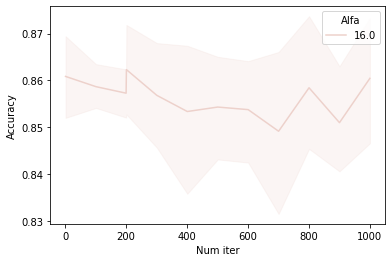

In [35]:
#kConMejorAccuracy(metodo = 0, folds = 5, n_from = 1, n_to = 51, step = 5)  

#float(str(0.000001))

numIterYAlfaConMejorAccuracy(folds, 16, 16, 1, 201, 201, 1)

# df_resultado = pd.read_csv("./resultados/resultado.csv")
# df_resultado = df_resultado[df_resultado["Método"] == 1]
# #df_resultado = df_resultado[(df_resultado["Numero de iteraciones"] == 701) | (df_resultado["Numero de iteraciones"] == 751) | (df_resultado["Numero de iteraciones"] == 761) | (df_resultado["Numero de iteraciones"] == 771) |(df_resultado["Numero de iteraciones"] == 781) |(df_resultado["Numero de iteraciones"] == 791) |(df_resultado["Numero de iteraciones"] == 801)]
# df_resultado = df_resultado[((df_resultado["Numero de iteraciones"] - 1) % 100 == 0)]
# fig = sns.lineplot(data=df_resultado, x='Alfa', y='Accuracy', hue='Numero de iteraciones');
# fig.set(xlabel='Alfa', ylabel='Accuracy');
# handles, labels = fig.get_legend_handles_labels()
# fig.legend(handles=handles[0:], labels=labels[0:], title= "Numero de iteraciones")
# #plt.savefig("../rendimiento-LU-una-inst.svg");

# df_resultado = pd.read_csv("./resultados/resultado.csv")
# df_resultado = df_resultado[df_resultado["Método"] == 1]
# #df_resultado = df_resultado[(df_resultado["Numero de iteraciones"] == 701) | (df_resultado["Numero de iteraciones"] == 751) | (df_resultado["Numero de iteraciones"] == 761) | (df_resultado["Numero de iteraciones"] == 771) |(df_resultado["Numero de iteraciones"] == 781) |(df_resultado["Numero de iteraciones"] == 791) |(df_resultado["Numero de iteraciones"] == 801)]
# df_resultado = df_resultado[((df_resultado["Numero de iteraciones"] - 1) % 100 == 0)]
# fig2 = sns.lineplot(data=df_resultado, x='Alfa', y='Tiempo', hue='Numero de iteraciones');
# fig2.set(xlabel='Alfa', ylabel='Tiempo (ms)');
# handles, labels = fig2.get_legend_handles_labels()
# fig2.legend(handles=handles[0:], labels=labels[0:], title= "Numero de iteraciones")
# #plt.savefig("../rendimiento-LU-una-inst.svg");


df_resultado = pd.read_csv("./resultados/resultado.csv")
df_resultado = df_resultado[df_resultado["Método"] == 1]
#df_resultado = df_resultado[(df_resultado["Numero de iteraciones"] == 701) | (df_resultado["Numero de iteraciones"] == 751) | (df_resultado["Numero de iteraciones"] == 761) | (df_resultado["Numero de iteraciones"] == 771) |(df_resultado["Numero de iteraciones"] == 781) |(df_resultado["Numero de iteraciones"] == 791) |(df_resultado["Numero de iteraciones"] == 801)]
df_resultado = df_resultado[(df_resultado["Alfa"] == 16)]
fig = sns.lineplot(data=df_resultado, x='Numero de iteraciones', y='Accuracy', hue='Alfa');
fig.set(xlabel='Num iter', ylabel='Accuracy');
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles=handles[0:], labels=labels[0:], title= "Alfa")
#plt.savefig("../rendimiento-LU-una-inst.svg");